In [1]:
import re, string,os
from glob import glob as gb
import pandas as pd
from collections import Counter
from tqdm import tqdm
from utils.functions import *
import seaborn as sns 
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

In [2]:
project_path = '/home/ruben/Documents/GitHub/CrisisBureaucracy'
data_path = '/media/ruben/Elements/PhD/data/hansard'

In [86]:
# Load all sentences with 'bureaucracy' (not just annotated set, but everything: 4080 texts)
df = pd.read_csv('~/Documents/GitHub/CrisisBureaucracy/data/classifier/bureaucracy-sentences-full.tsv',sep='\t').dropna()
df['text'] = [load_full("-".join(x.split('-')[1:-1]))[0] for x in tqdm(df['id'])]
df = df[['id','text']]

100%|██████████| 4080/4080 [00:59<00:00, 68.90it/s]


In [87]:
# Load a sample of 500 debates for TFIDF Vectorizer (> 400.000 speech-paragraphs)
sample_ = random.sample(gb(f'{data_path}/lemmatized_pm/*'),500)
sample_df = pd.DataFrame()

for s in tqdm(sample_):
    s = pd.read_csv(s,sep='\t')
    sample_df = sample_df.append(s)
sample_df = sample_df.dropna().reset_index(drop=True)

100%|██████████| 500/500 [01:47<00:00,  4.66it/s]


In [88]:
# Reset metadata columns
sample_df['id'] = [sample_df['speech_member_ref'][c][5:] + '-' + x[10:] + "-" + sample_df['speech_member_party'][c].replace(' ','_').lower() for c,x in enumerate(sample_df['id'])]
sample_df = sample_df[['id','text_lemmatized']]
sample_df.columns = "id text".split(' ')
df = df.append(sample_df)
df = df.reset_index(drop=True)

# Split metadata to columns
df['year'] = [int(x.split('-')[1]) for x in df.id]
df['party'] = [str(x.split('-')[-1]) for x in df.id]
df['id'] = ["-".join(x.split('-')[1:-1]) for x in df.id]

In [89]:
# Preprocess text (remove stopwords, remove punctuation, lowercase)
df['text'] = utils.preprocess_(df['text'],stopwords=stopwords.words('english') + "hon member friend gentleman gentlemen speaker right".split(' '))

In [133]:
# Get Category Lexicons
lex_df = pd.read_csv(project_path + '/data/classifier/lexicon-small.csv')
lex_ = {c:[w for w in lex_df[c] if str(w) != 'nan'] for c in lex_df.columns}
vocab = list(set([item for sublist in list(lex_.values()) for item in sublist if str(item) != "nan"]))

In [135]:
# Create TFIDF Matrix with category lexicon as vocab
tfidf_vec = TfidfVectorizer(vocabulary=vocab,ngram_range=(1,3),max_df=0.5,min_df=0.01,smooth_idf=True)
mtrx = tfidf_vec.fit_transform(df.text)
dfm = pd.DataFrame.sparse.from_spmatrix(mtrx)
dfm.index = df.id 
dfm.columns = vocab

In [167]:
# Aggregate Clusters in Matrix
dfm_ = pd.DataFrame()

for k,v in lex_.items():
    dfm_[k] = dfm[v].sum(axis=1) # summing the tfidf scores per category
dfm_['year'] = [int(x.split('-')[0]) for x in dfm_.index]
dfmd = dfm_.groupby('year').sum().T

# # Normalise per Year and transform to rolling window
for c in list(dfmd.columns):
    dfmd[c] = dfmd[c] / dfmd[c].sum()
dfmd = dfmd.T.reset_index()

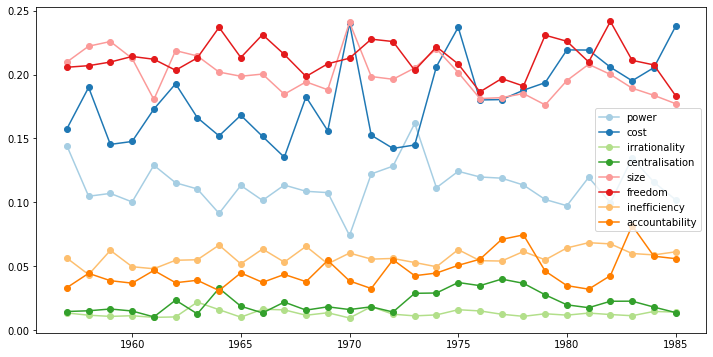

In [168]:
## Create plot with averages / year

data = dfm_
fig, ax = plt.subplots(figsize=(12,6))
for c,cl in enumerate("power cost irrationality centralisation size freedom inefficiency accountability".split(' ')):
    # plt.scatter(x=data['year'],y=data[cl],alpha=.1) for scatterplots, not necessary
    avgs = pd.DataFrame([[m,data[data['year'] == m][cl].sum() / len(data[data['year'] == m])] for m in set(data['year'])],columns=['year',cl]).sort_values('year')
    # rm = avgs[cl].rolling(3, win_type='gaussian').mean(std=2)
    plt.plot(avgs['year'],avgs[cl],label=cl,marker='o',c=sns.color_palette('Paired',9)[c])
plt.legend()

In [162]:
d = dfm_.reset_index()
d['party'] =  df['party']

power


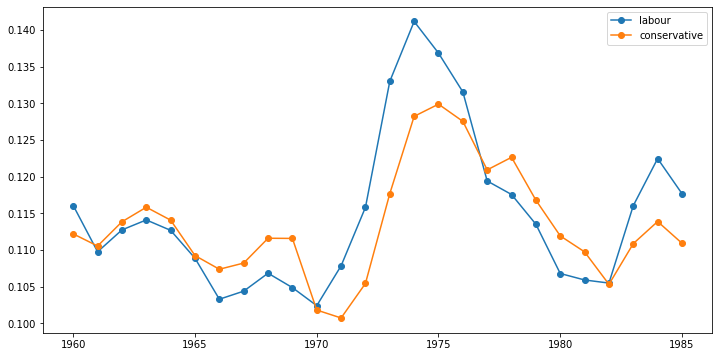

cost


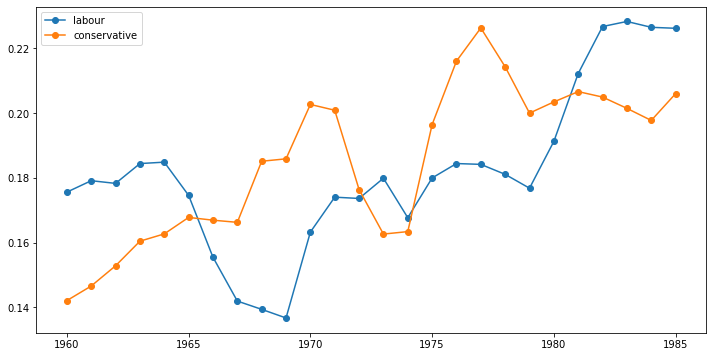

irrationality


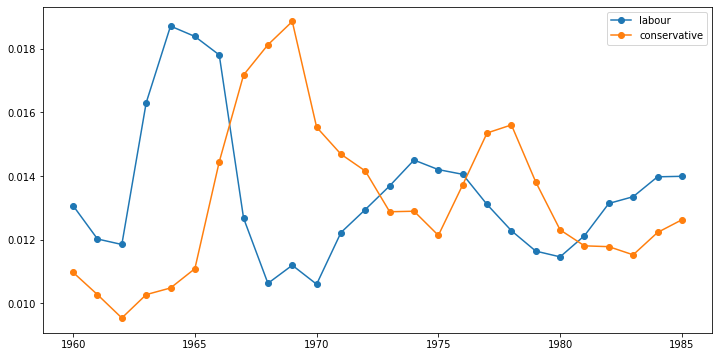

centralisation


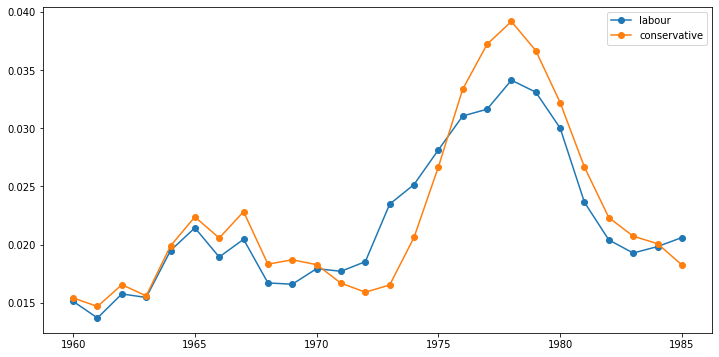

size


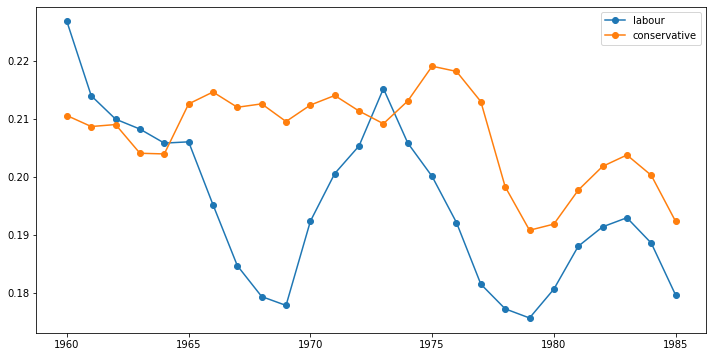

freedom


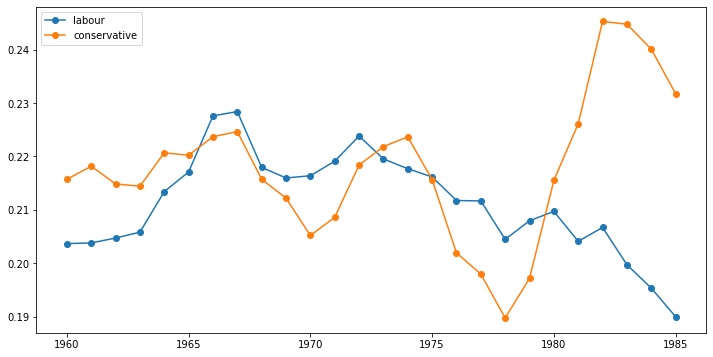

inefficiency


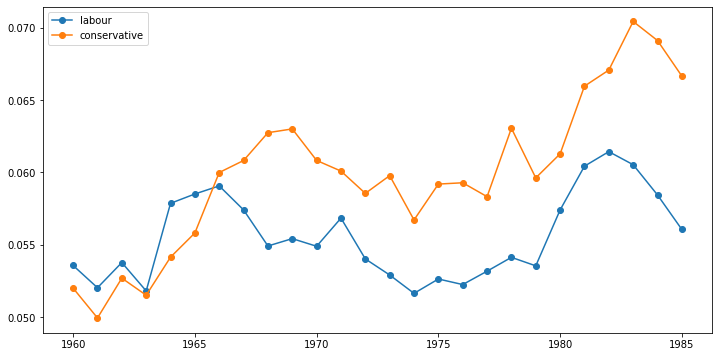

accountability


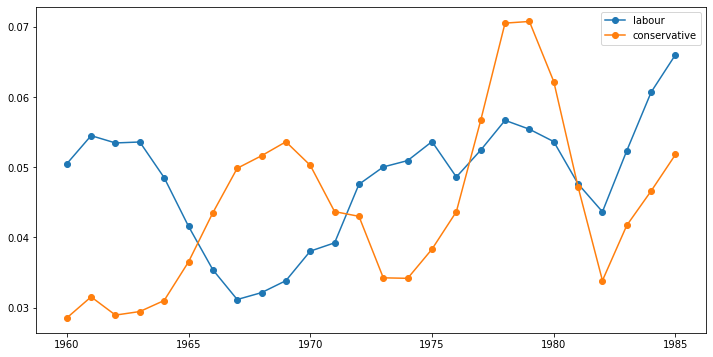

In [166]:
# Plot average argument score per category per party

for cl in "power cost irrationality centralisation size freedom inefficiency accountability".split(' '):
    print(cl)
    fig, ax = plt.subplots(figsize=(12,6))
    for p in ["labour","conservative"]:
        data = d[d['party'] == p]
        avgs = pd.DataFrame([[m,data[data['year'] == m][cl].sum() / len(data[data['year'] == m])] for m in set(data['year'])],columns=['year',cl]).sort_values('year')
        rm = avgs[cl].rolling(4, win_type='gaussian').mean(std=3)
        plt.plot(avgs['year'],rm,label=p,marker='o')
    plt.legend()
    plt.show()
    plt.close()